In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set(font_scale=2)

#splitting the data
from sklearn.model_selection import train_test_split

#Scaling the data - normalization and encoding
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

#oversampling techinque for imbalance
from imblearn.over_sampling import SMOTE

# Our predicting model
from sklearn.ensemble import RandomForestClassifier

#evaluation metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
#evaluation plots
from yellowbrick.classifier import (
    DiscriminationThreshold,
    PrecisionRecallCurve
)


#### Reading data and basic descriptive stats
I will remove the 'Complain' feature, since it is very similar to the target variable 'Exited'. It may be that the customers complained right before leaving, so this variable doesn't really help us to predict.

In [4]:
data = pd.read_csv('Customer-Churn-Records.csv')
data = data.drop('Complain',axis=1)
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [5]:
display(data.describe())
display(data.describe(include='object'))

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,5.000000,1000.000000


,Surname,Geography,Gender,Card Type
count,10000,10000,10000,10000
unique,2932,3,2,4
top,Smith,France,Male,DIAMOND
freq,32,5014,5457,2507


#### Checking for missing values

In [6]:
#Check for missing values
data.isnull().sum()

RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

#### Making sure that each customer id appears only once

In [7]:
data['CustomerId'].value_counts(ascending=False)

CustomerId
15656710    1
15768163    1
15672754    1
15719276    1
15692664    1
           ..
15737888    1
15701354    1
15619304    1
15647311    1
15634602    1
Name: count, Length: 10000, dtype: int64

#### Grouping features to categorical and numerical and splitting data to train and test

In [8]:
to_remove = ['CustomerId', 'RowNumber', 'Surname']
data = data.drop(columns=to_remove)
#quick separation to categorical and numerical features
target = ['Exited']
cat_feats = ['Geography', 'Gender', 'Card Type', 'Satisfaction Score', 'IsActiveMember', 'HasCrCard']
num_feats = [col for col in data if col not in (cat_feats+target)]


In [9]:
X = data.drop(target, axis=1)
y = data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#validation
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 13), (2000, 13), (8000,), (2000,))

#### EDA

Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64

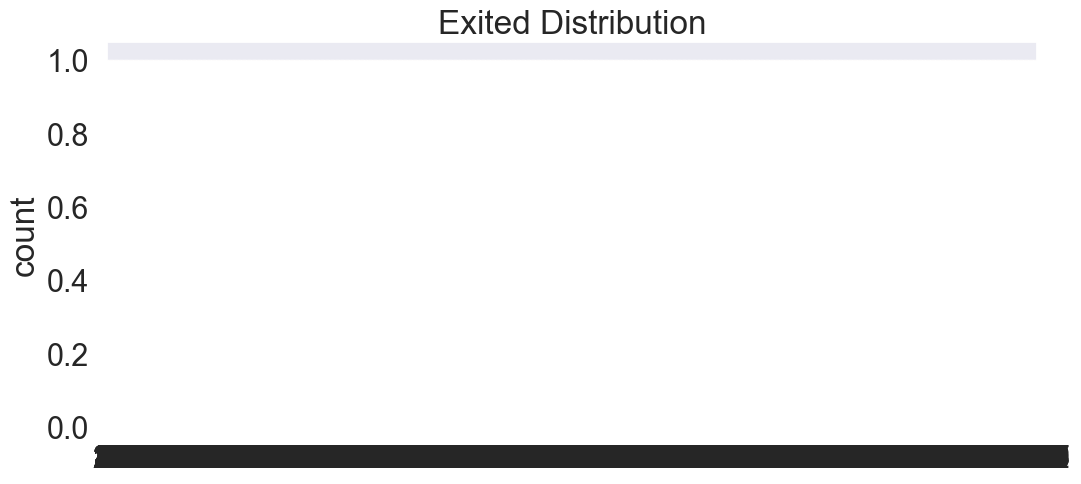

In [10]:
f = plt.figure(figsize=(12,5))

sns.countplot(y_train, color='darkred')
plt.title('Exited Distribution')

display(y_train.value_counts(normalize=True))

Comment: We have an imbalanced case

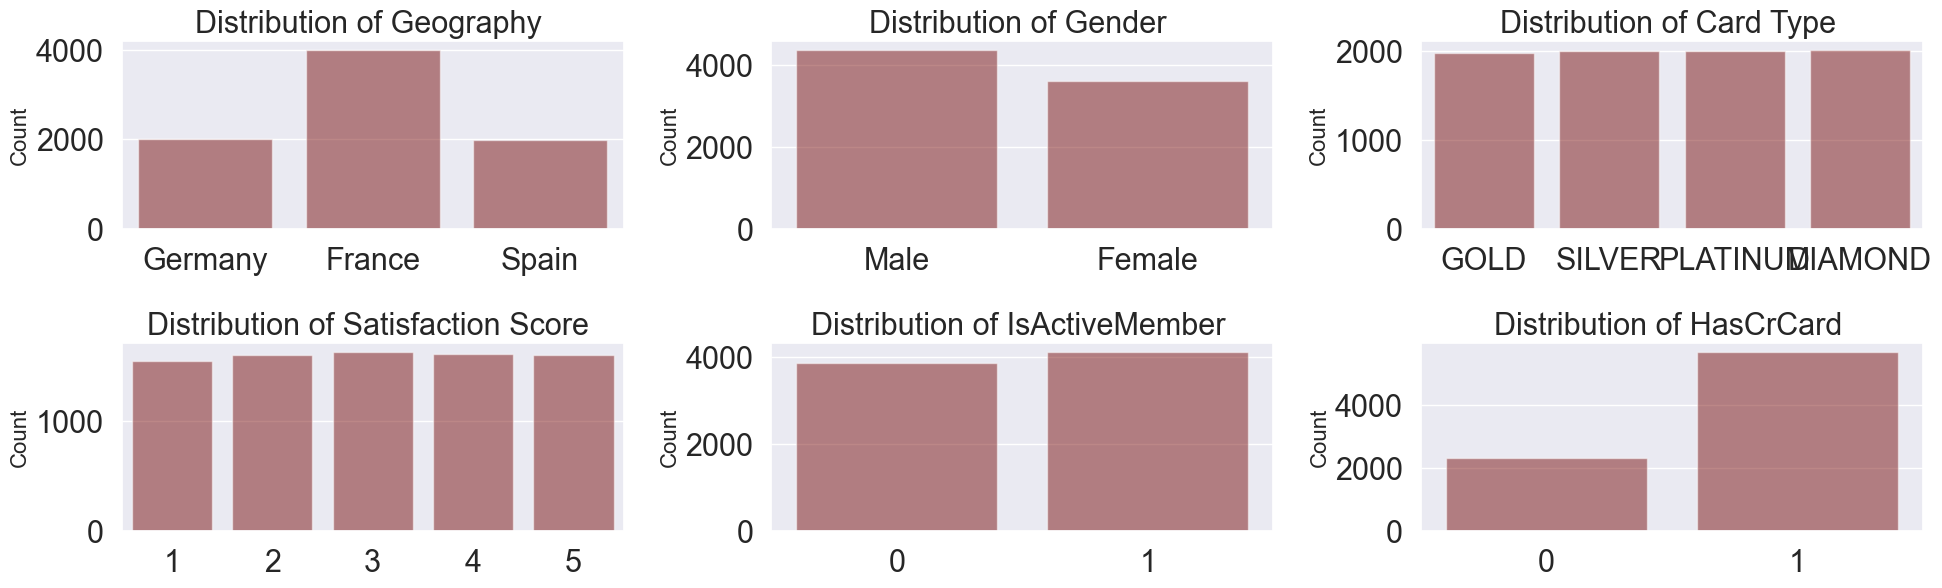

In [11]:
#plotting the distirbutions of the categorical variables
f = plt.figure(figsize=(20,15))

for i, col in enumerate(cat_feats):


    plt.subplot(5,3, i+1)
    if len(X_train[col].unique()) <= 5:
        sns.countplot(data=X_train, x=col, color='darkred', alpha=0.5)
        plt.ylabel("Count", fontdict={'fontsize':16})
    else:
        sns.countplot(data=X_train, y=col, order=X_train[col].value_counts().index,color='darkred',alpha=0.5)
    plt.title(f"""Distribution of {col} """, fontdict={'fontsize':22})
    plt.xlabel("")
    #plt.ylabel("")

plt.tight_layout()
plt.savefig("Categorical distributions")
plt.show()

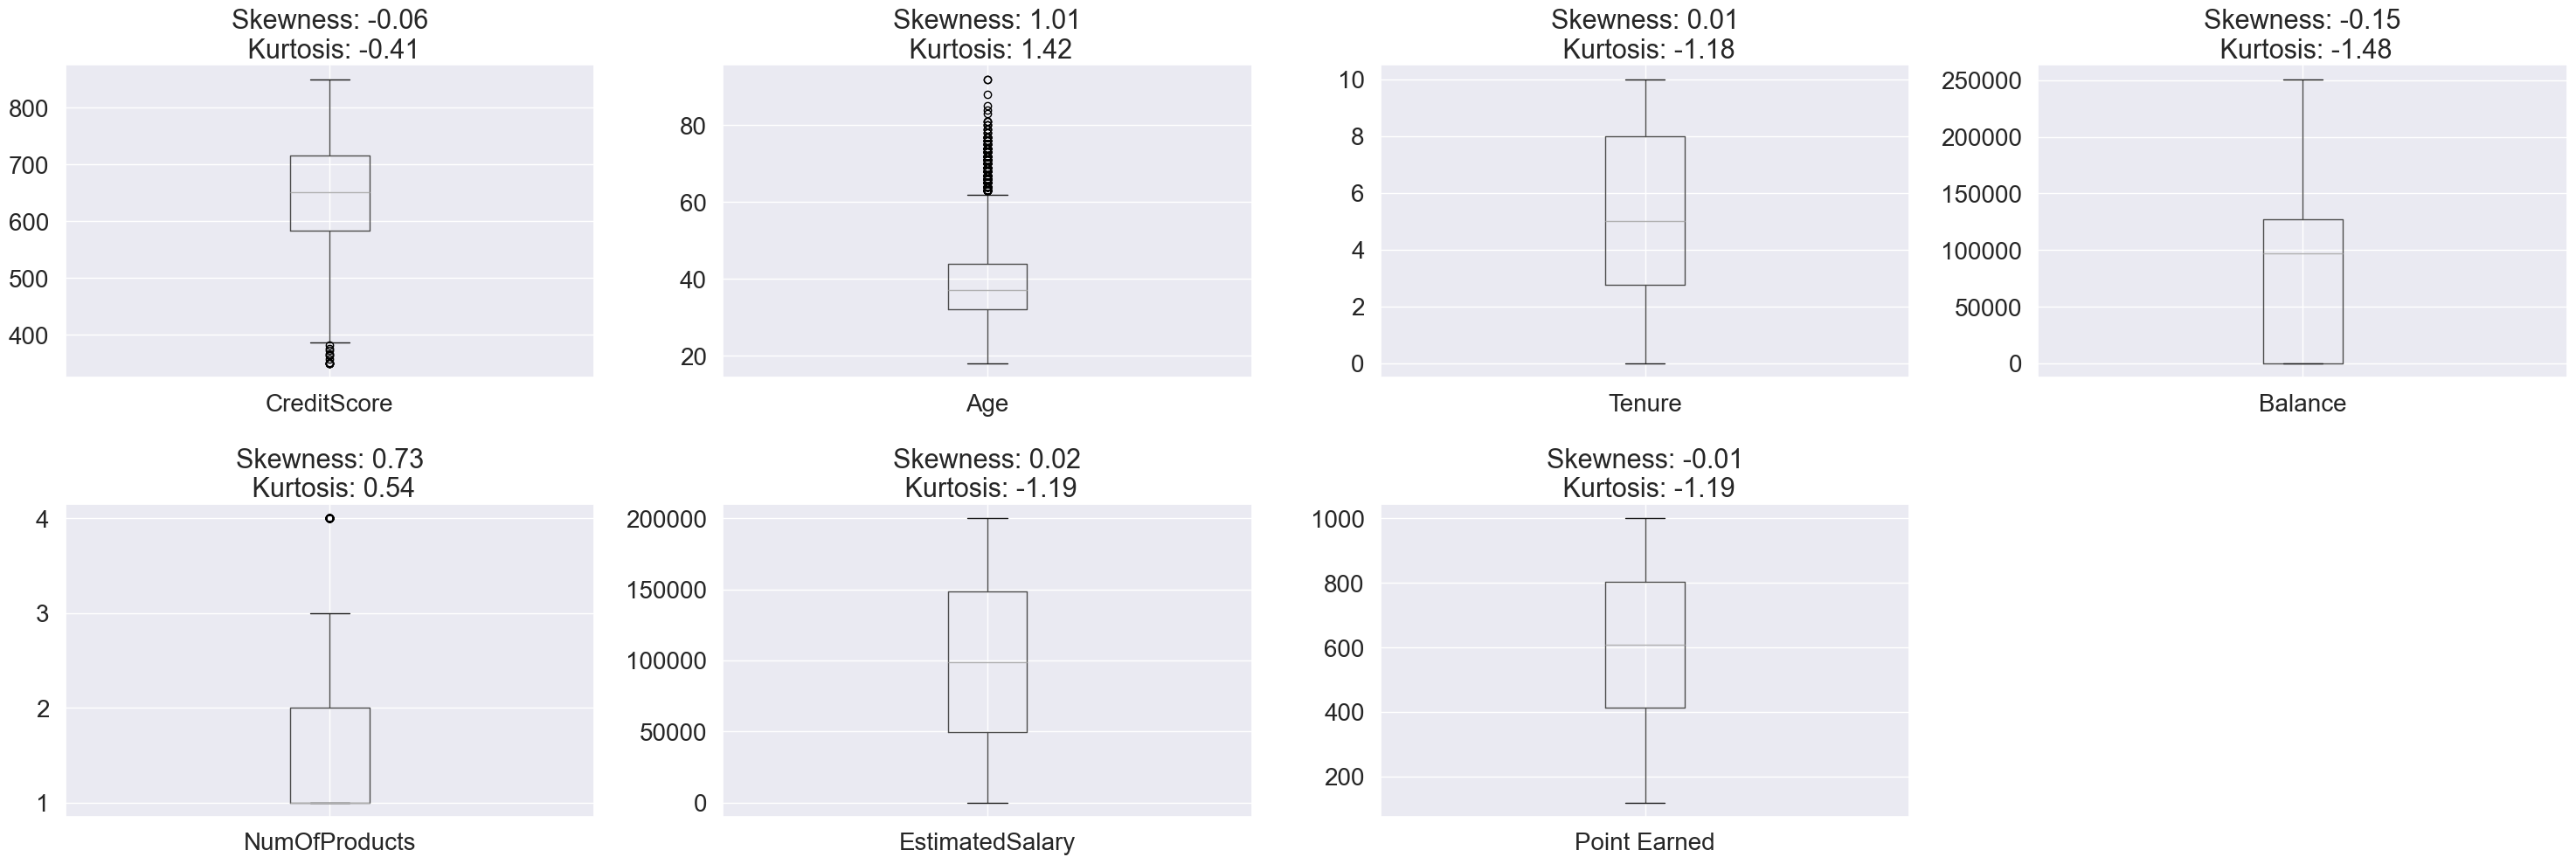

In [12]:
#plotting the distributions of the numerical variables
sns.set_style("darkgrid")
plt.figure(figsize=(30,15))
for i,col in enumerate(num_feats):
    plt.subplot(3,4,i+1)
    X_train[[col]].boxplot(fontsize=20)
    plt.title(f'Skewness: {np.round(X_train[col].skew(),2)}\n Kurtosis: {np.round(X_train[col].kurt(),2)}',
              fontdict={'fontsize':22})
    plt.savefig("cont variables")
    plt.tight_layout();

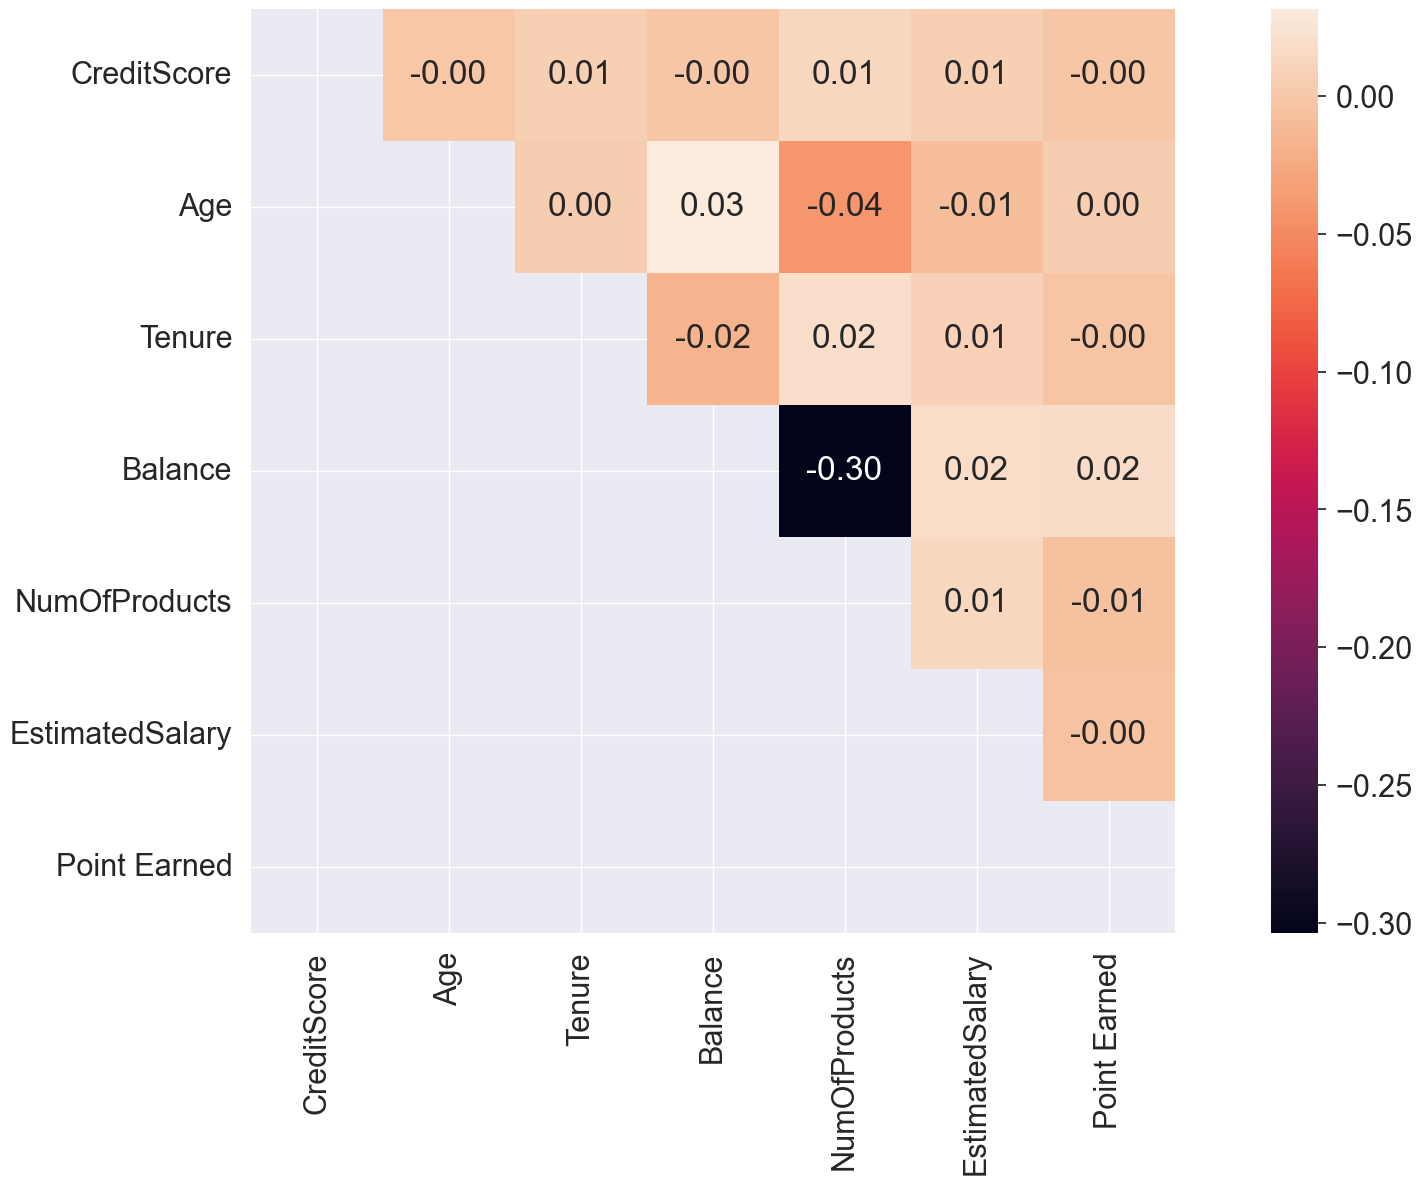

In [13]:
#correlation matrix
corr = X_train[num_feats].corr()

plt.figure(figsize=(25,12))
mask = np.tril(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt=".2f", mask = mask, square = True)
plt.show()

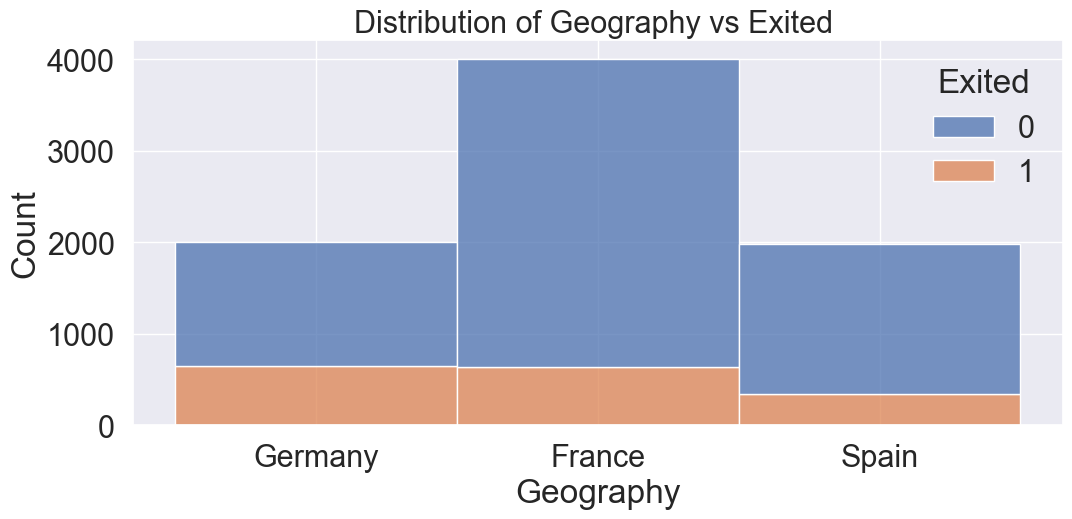

Overall frequency: 


Geography
France     0.501
Germany    0.251
Spain      0.248
Name: proportion, dtype: float64

**************************************************


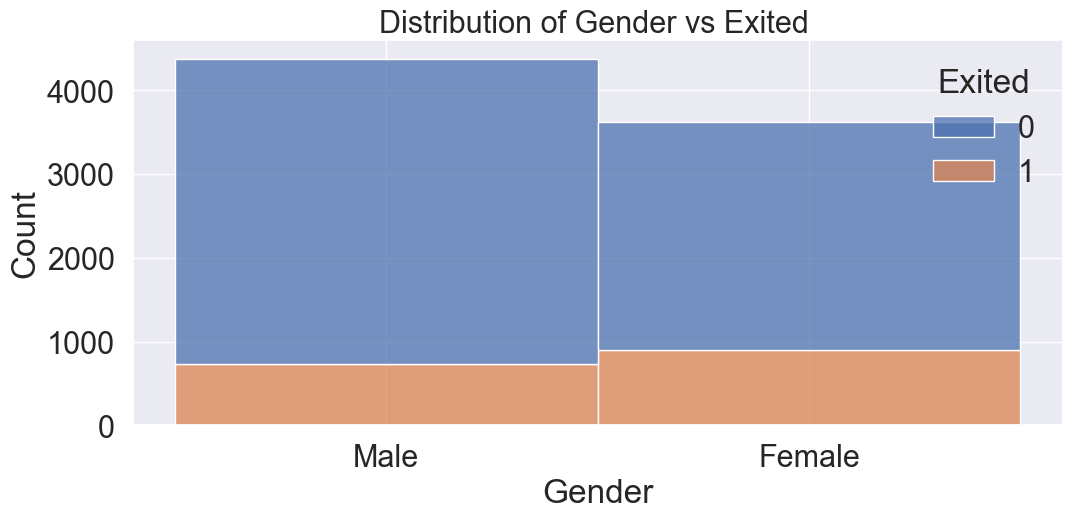

Overall frequency: 


Gender
Male      0.546875
Female    0.453125
Name: proportion, dtype: float64

**************************************************


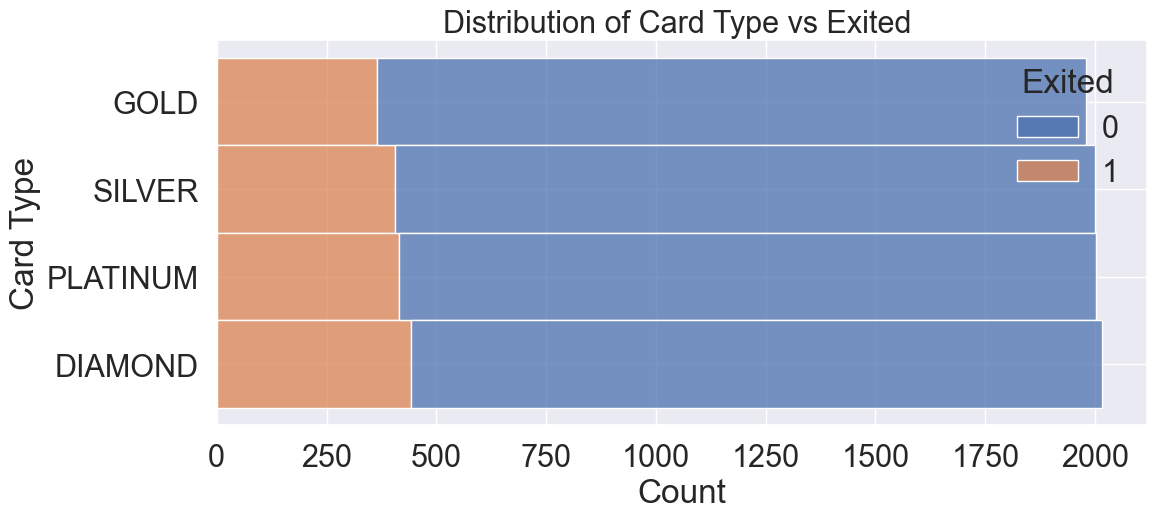

Overall frequency: 


Card Type
DIAMOND     0.252125
PLATINUM    0.250375
SILVER      0.250125
GOLD        0.247375
Name: proportion, dtype: float64

**************************************************


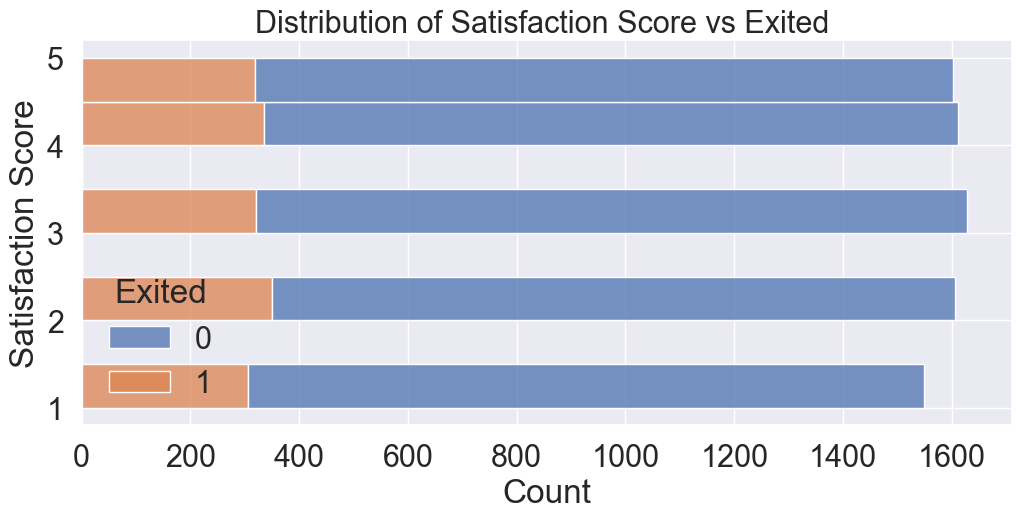

Overall frequency: 


Satisfaction Score
3    0.203625
4    0.201500
2    0.200750
5    0.200375
1    0.193750
Name: proportion, dtype: float64

**************************************************


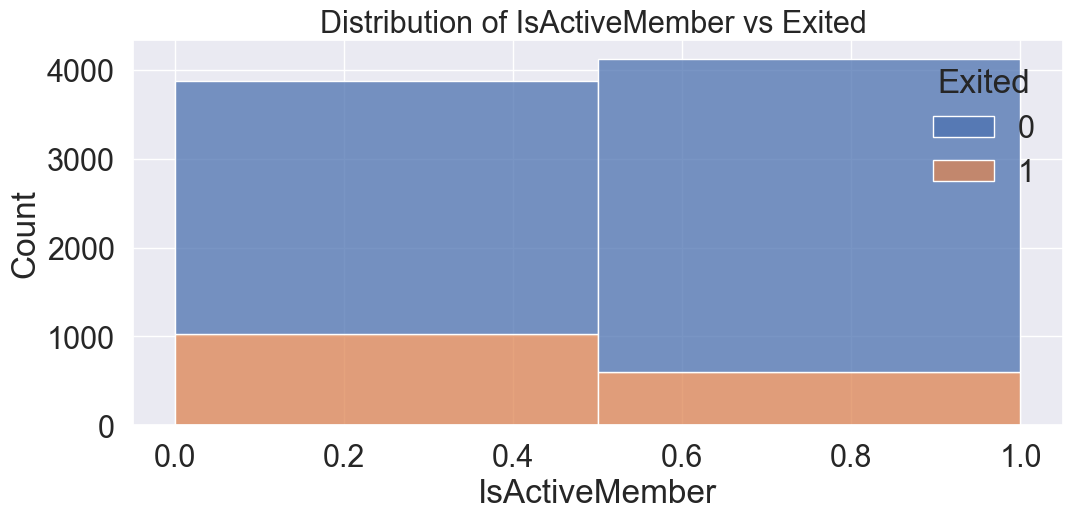

Overall frequency: 


IsActiveMember
1    0.515375
0    0.484625
Name: proportion, dtype: float64

**************************************************


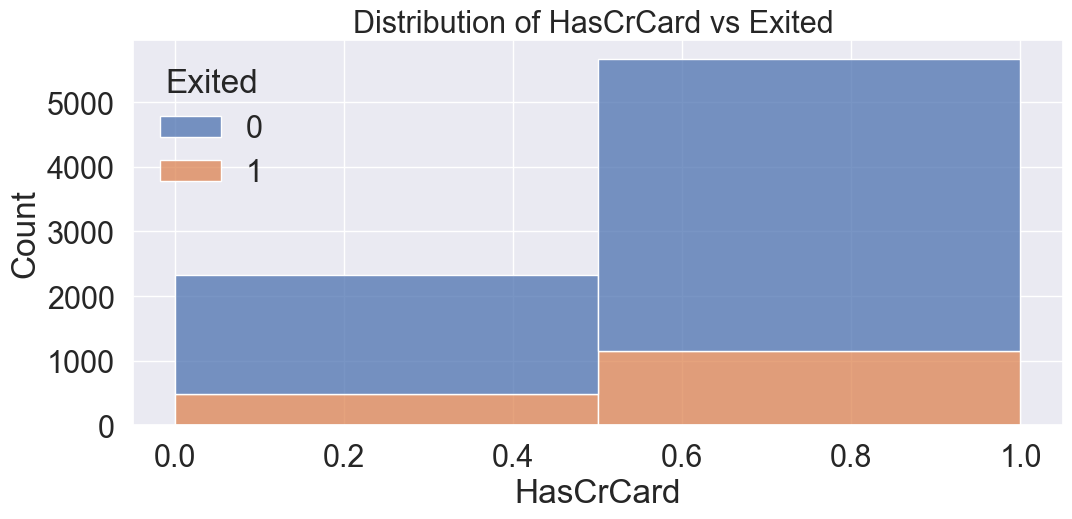

Overall frequency: 


HasCrCard
1    0.709
0    0.291
Name: proportion, dtype: float64

**************************************************


In [14]:
#Target variable vs categorical predictors


df_train = pd.concat([X_train, y_train],axis=1)


for col in cat_feats:
    if col in df_train.columns:
        plt.figure(figsize=(12,5))
        if len(X_train[col].unique()) < 4:
            sns.histplot(binwidth=0.5, x=col, hue=y_train, data=X_train, stat="count", multiple="stack", bins=10)
        else:
            sns.histplot(binwidth=0.5, y=col, hue=y_train, data=X_train, stat="count", multiple="stack", bins=10)
        plt.title(f"""Distribution of {col} vs Exited """, fontdict={'fontsize':22})
        plt.show()

        print('Overall frequency: ')
        display(X_train[col].value_counts(normalize=True))

        print()

        unique_values = df_train[col].unique()
        odds_dict = {}
        for unique_val in unique_values:
            is_claimed_vals = len(df_train.loc[(df_train['Exited']==1) & (df_train[col]==unique_val)])
            is_not_claimed_vals = len(df_train.loc[(df_train['Exited']==0) & (df_train[col]==unique_val)])
            odds_dict[unique_val] = round(is_claimed_vals/(is_not_claimed_vals+0.000001)*100, 2)

        odds_df = pd.Series(odds_dict, name=f'{col}_odds_ratio - Exited/Not Exited (%)').reset_index() \
            .rename(columns={'index':'Categories'})

        fig = go.Figure(data=[go.Table(
            header=dict(values=list(odds_df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[odds_df[val] for val in odds_df.columns],
                       fill_color='lavender',
                       align='left'))
        ])
        fig.update_layout(
            autosize=False)
        fig.show()

        print('*'*50)

Comment:
 - We can see that the odds ratio for customers that exited vs not exited is higher in Germany, meaning that Geography can help us understand some of the reason for customer churn.
- We can see that the odds ratio for customers that exited vs not exited is higher in the female group (Gender), meaning that Gender can help us understand some of the reason for customer churn (More women leave the bank).


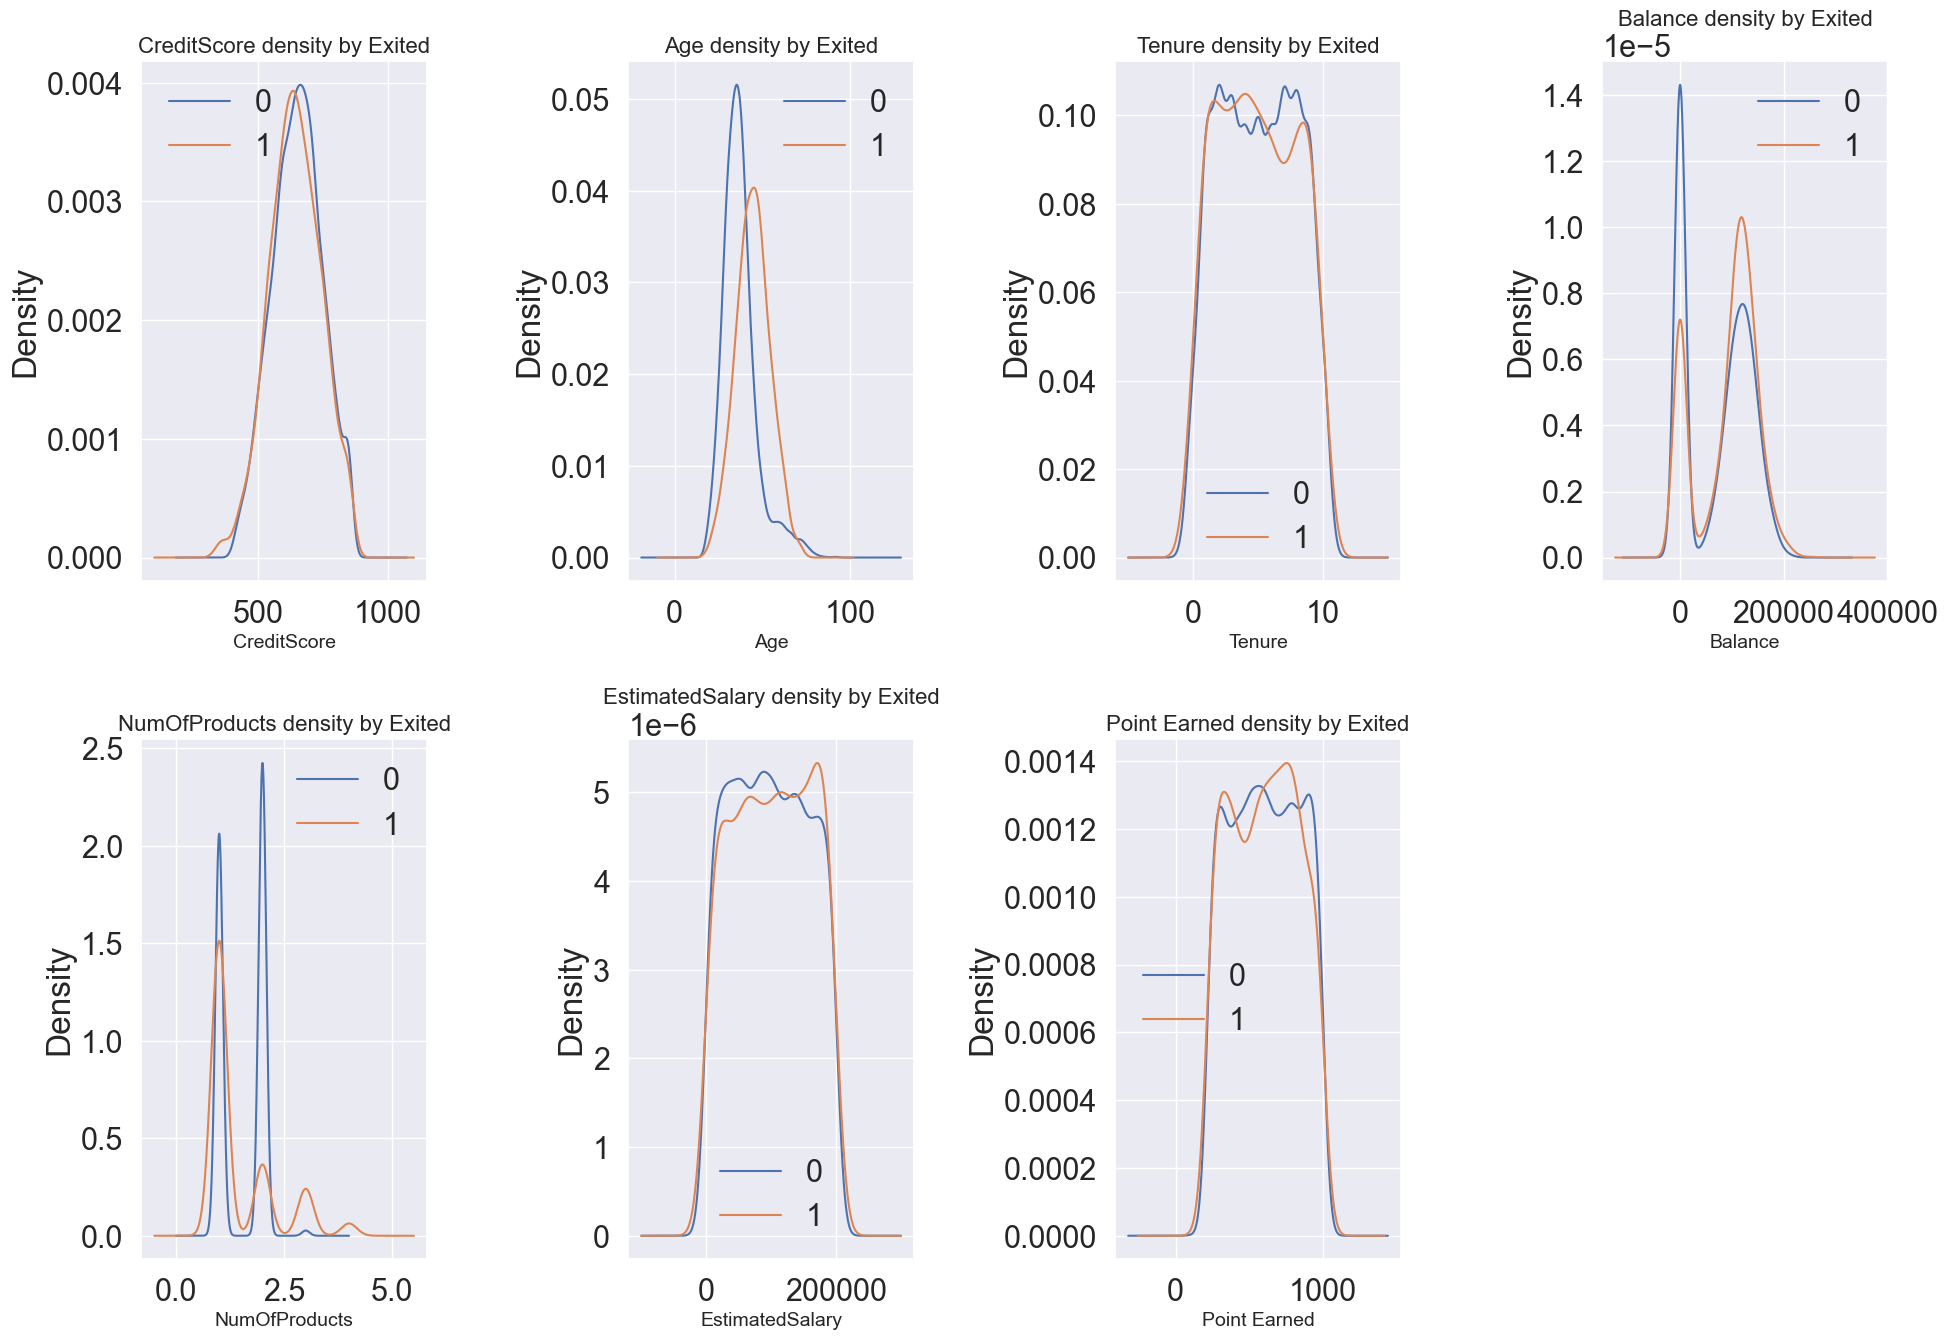

In [15]:
#Predicted feature vs numerical features

df_train = pd.concat([X_train, y_train],axis=1)
#f = plt.figure(figsize=(20,20))

for i, col in enumerate(num_feats):
    plt.subplot(3,4, i+1)

    df_train.groupby('Exited')[col].plot(kind='kde', figsize=(20, 20))
    plt.legend()
    plt.title(col + ' density by Exited',fontdict={'fontsize':16})
    plt.xlabel(col,fontdict={'fontsize':14})

plt.tight_layout()
plt.savefig("numerical vs Exited")
plt.show()

Comment:
 - We can see number of differences between customers that exited and customers that didn't. It seems that older customers tend to churn more.


#### Preprocessing
1) one hot encoding to nominal categorical features
2) Mapping the ordinal categorical features that need to be mapped.
3) Min Max scaling the data

In [16]:
#relevant categorical features
nominal_cat_feats = ['Gender', 'Geography']

One hot encoding -

In [17]:
encoder = OneHotEncoder(sparse=False)
nominal_mat = encoder.fit_transform(X_train[nominal_cat_feats])
nominal_df = pd.DataFrame(nominal_mat,
                          columns=encoder.get_feature_names_out(),
                          index=X_train.index)

X_train = X_train.drop(columns=nominal_cat_feats)
X_train = pd.concat([X_train, nominal_df],axis=1)

TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
nominal_mat_test = encoder.transform(X_test[nominal_cat_feats])
nominal_df_test = pd.DataFrame(nominal_mat_test,
                               columns=encoder.get_feature_names_out(),
                               index=X_test.index)

X_test = X_test.drop(columns=nominal_cat_feats)
X_test = pd.concat([X_test, nominal_df_test],axis=1)

Ordinal encoding mapping -

In [ ]:
encoder = OrdinalEncoder(categories=[np.array(['SILVER','GOLD', 'PLATINUM','DIAMOND'],dtype=object)])
X_train['Card Type'] = encoder.fit_transform(X_train[['Card Type']])
X_test['Card Type'] = encoder.transform(X_test[['Card Type']])

Min Max scaler

In [ ]:
sc = MinMaxScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)


Oversampling the data, due to imbalance, using the SMOTE method

In [ ]:
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5
)

X_res, y_res = sm.fit_resample(X_train_sc, y_train)

#### Modeling

Only random forest classifier will be used

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_res, y_res)

preds = rf.predict(X_test_sc)

#### Model Evaluation

In [ ]:
print('F-measure Random Forest test:', f1_score(y_test, preds, pos_label=1))
print('Recall Random Forest test:', recall_score(y_test, preds, pos_label=1))
print('Precision Random Forest test:', precision_score(y_test, preds))


F-measure Random Forest test: 0.608142493638677
Recall Random Forest test: 0.5857843137254902
Precision Random Forest test: 0.6322751322751323


In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1592
           1       0.63      0.59      0.61       408

    accuracy                           0.85      2000
   macro avg       0.76      0.75      0.76      2000
weighted avg       0.84      0.85      0.84      2000



C:\Users\essdr\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



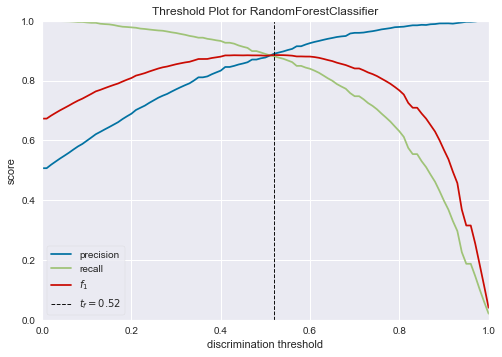

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [ ]:
visualizer = DiscriminationThreshold(rf,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")

visualizer.fit(X_res, y_res)        # Fit the visualizer and the model
visualizer.score(X_test_sc, y_test)        # Evaluate the model on the test data
visualizer.show()

C:\Users\essdr\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



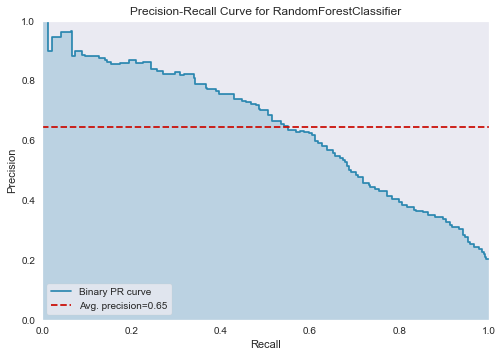

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
visualizer = PrecisionRecallCurve(rf, classes=[0, 1])

visualizer.fit(X_res, y_res)        # Fit the training data to the visualizer
visualizer.score(X_test_sc, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure